In [29]:
import pandas as pd
import networkx as nx
import numpy as np
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from utils import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os.path
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# Generate the deepwalk file from the train graph
# from deepwalk import DeepWalk


In [31]:
# Load train samples 
with open("train.txt", "r") as f:
    reader = csv.reader(f)
    train_set = list(reader)
train_set = [element[0].split(" ") for element in train_set]
train_set[:4]

[['939', '3809', '1'],
 ['2442', '5784', '1'],
 ['179', '3809', '1'],
 ['857', '2280', '1']]

In [32]:
# Load train samples 
with open("test.txt", "r") as f:
    reader = csv.reader(f)
    test_set = list(reader)
test_set = [element[0].split(" ") for element in test_set]
test_set[:4]

[['3425', '4524'], ['1620', '2617'], ['4832', '6317'], ['4984', '7298']]

In [33]:
# Convert train set into a graph
G = nx.Graph()
for edge in train_set:
    G.add_edge(edge[0], edge[1])
print("The number of nodes: {}".format(G.number_of_nodes()))
print("The number of edges: {}".format(G.number_of_edges()))
# Check that the graph is connected
print("The number of connected components: {}".format(nx.number_connected_components(G)))

The number of nodes: 3597
The number of edges: 10496
The number of connected components: 1


In [34]:
# Convert train set into a graph
G_test = nx.Graph()
for edge in test_set:
    G_test.add_edge(edge[0], edge[1])
print("The number of nodes: {}".format(G_test.number_of_nodes()))
print("The number of edges: {}".format(G_test.number_of_edges()))
# Check that the graph is connected
print("The number of connected components: {}".format(nx.number_connected_components(G_test)))

The number of nodes: 2856
The number of edges: 3498
The number of connected components: 149


In [6]:
# train_samples, train_labels, test_samples = [(element[0],element[1]) for element in train_set], [element[2] for element in train_set], [(element[0],element[1]) for element in test_set],
# # Convert labels into integers
# train_labels = [int(label) for label in train_labels]
# train_labels[:4]

In [7]:
test_samples = [(element[0],element[1]) for element in test_set]

In [8]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(G) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Store the shuffled list of current edges of the graph
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive test samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    train_set_size = graph.number_of_edges() - test_set_size
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks
    for edge in edges:
        
        # Remove the edge
        residual_g.remove_edge(edge[0], edge[1])
        
        # Add the removed edge to the positive sample list if the network is still connected
        if nx.is_connected(residual_g):
            num_of_pos_test_samples += 1
            test_pos_samples.append(edge)
        # Otherwise, re-add the edge to the network
        else: 
            residual_g.add_edge(edge[0], edge[1])
        
        # If we have collected enough number of edges for testing set, we can terminate the loop
        if num_of_pos_test_samples == test_set_size:
            break
    
    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks
    non_edges = list(nx.non_edges(graph))
    np.random.shuffle(non_edges)
    
    train_neg_samples = non_edges[:train_set_size] 
    test_neg_samples = non_edges[train_set_size:train_set_size + test_set_size]

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels


In [9]:
# --- Construct the training and testing sets ---
residual_g, train_samples, train_labels, val_samples, val_labels = generate_samples(graph=G, train_set_ratio=0.8)


In [10]:
#Import information about nodes (index represents the node id)
node_information = pd.read_csv('./node_information.csv', header=None)
node_information.rename(columns = {0:'node_id'}, inplace = True)
print(list(node_information.loc[node_information['node_id'] == 939].iloc[0,:]))
node_information

[939.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

,node_id,1,2,3,4,5,6,7,8,9,...,923,924,925,926,927,928,929,930,931,932
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,7584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3593,7589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3594,7593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3595,7594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
def feature_extractor(graph, samples, node_information):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = [] 
    deg_centrality = nx.degree_centrality(graph)
    print('Calculate betweeness centrality')
    # Betweeness centrality measure
    #betweeness_centrality = nx.betweenness_centrality(graph)
    print('Calculate features for each edge in the graph')
    print('Calculate features for each edge in the graph')
    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]
        source_node_information = list(node_information.loc[node_information['node_id'] == int(source_node)].iloc[0, 1:])
        target_node_information = list(node_information.loc[node_information['node_id'] == int(target_node)].iloc[0, 1:])
       
        # Degree Centrality  
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality  
        #diff_bt = betweeness_centrality[source_node] - betweeness_centrality[target_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node))
        if np.isinf(aai):
            print('aai is inf')
            aai = 0
        # Compute the Jaccard coefficient
        neighbords_source, neighbord_target = set(graph.neighbors(source_node)), set(graph.neighbors(target_node))
        inter = len(neighbords_source.intersection(neighbord_target))
        union = len(neighbords_source.union(neighbord_target)) 
        jacard_coeff = inter/union 
        if union == 0:
            print('union is 0')
            jacard_coeff = 0
        # Create edge feature vector with all metric computed above
        feature_edge_vector = np.array([source_degree_centrality, target_degree_centrality, pref_attach, aai, jacard_coeff])

         # Create edge feature vector with all metric computed above
        feature_vector.append(np.concatenate([source_node_information, target_node_information,feature_edge_vector]) ) 
    return feature_vector

In [12]:
# --- Create feature vector for all edges in training set and test set ---
train_features = feature_extractor(residual_g, train_samples, node_information)
val_features = feature_extractor(residual_g, val_samples, node_information)
test_features = feature_extractor(G, test_samples, node_information)
print(train_features[:4])
print(val_features[:4])
print(test_features[:4])

Calculate betweeness centrality
Calculate features for each edge in the graph
Calculate features for each edge in the graph


  3%|▎         | 437/16794 [00:01<00:45, 362.58it/s]C:\Users\Guillaume\AppData\Local\Temp\ipykernel_1744\3476036810.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node))
  3%|▎         | 510/16794 [00:01<00:46, 349.34it/s]

aai is inf


 14%|█▍        | 2345/16794 [00:06<00:37, 389.17it/s]

aai is inf


 20%|██        | 3412/16794 [00:09<00:39, 336.68it/s]

aai is inf


100%|██████████| 16794/16794 [00:46<00:00, 362.79it/s]


Calculate betweeness centrality
Calculate features for each edge in the graph
Calculate features for each edge in the graph


 49%|████▉     | 2069/4198 [00:05<00:06, 319.91it/s]

aai is inf


100%|██████████| 4198/4198 [00:11<00:00, 366.56it/s]


Calculate betweeness centrality
Calculate features for each edge in the graph
Calculate features for each edge in the graph


 47%|████▋     | 1635/3498 [00:04<00:04, 397.61it/s]

aai is inf


100%|██████████| 3498/3498 [00:09<00:00, 375.50it/s]

[array([ 0.,  0.,  0., ..., 15.,  0.,  0.]), array([ 0.,  0.,  0., ..., 21.,  0.,  0.]), array([ 0.,  0.,  0., ..., 36.,  0.,  0.]), array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.72200000e+03, 4.17032391e-01, 3.42465753e-03])]
[array([ 0.,  0.,  0., ..., 20.,  0.,  0.]), array([  0.,   0.,   0., ..., 234.,   0.,   0.]), array([ 0.,  0.,  0., ..., 24.,  0.,  0.]), array([ 0.,  0.,  0., ..., 30.,  0.,  0.])]
[array([0., 0., 0., ..., 6., 0., 0.]), array([ 0.,  0.,  0., ..., 24.,  0.,  0.]), array([ 0.,  0.,  0., ..., 35.,  0.,  0.]), array([ 0.,  0.,  0., ..., 27.,  0.,  0.])]


In [13]:
def prediction( model , train_features, train_labels, val_features, val_labels = None):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    model.fit(train_features, train_labels)
    train_preds = model.predict(train_features)
    val_preds =  model.predict(val_features)#
    if val_labels is not None:
        print("Accuracy: ", accuracy_score(val_labels, val_preds))
        print("Precision: ", precision_score(val_labels, val_preds))
        print("Recall: ", recall_score(val_labels, val_preds))
        print("F1: ", f1_score(val_labels, val_preds))
        print("Confusion matrix: ", confusion_matrix(val_labels, val_preds))
        # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
        fpr, tpr, _ = roc_curve(val_labels, val_preds)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(6,6))
        plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()
        # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    fpr, tpr, _ = roc_curve(train_labels, train_preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
 
    return train_preds, val_preds

In [20]:
#model = LogisticRegression()
# Model SVC
model = SVC(kernel='linear')
# Model Random Forest
# model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

Accuracy:  0.6105288232491662
Precision:  0.6423312883435582
Recall:  0.49880895664602193
F1:  0.5615446500402252
Confusion matrix:  [[1516  583]
 [1052 1047]]


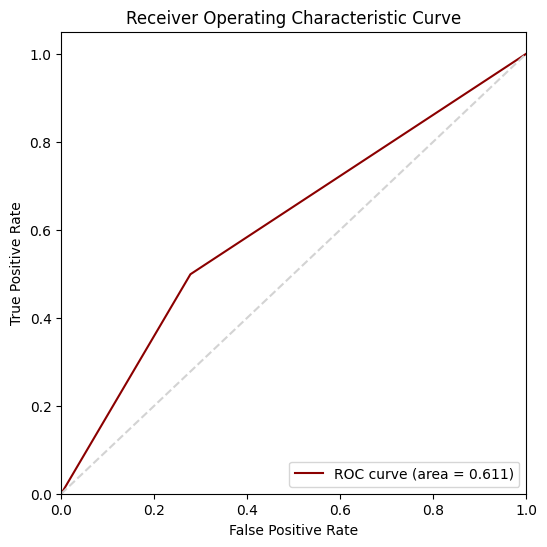

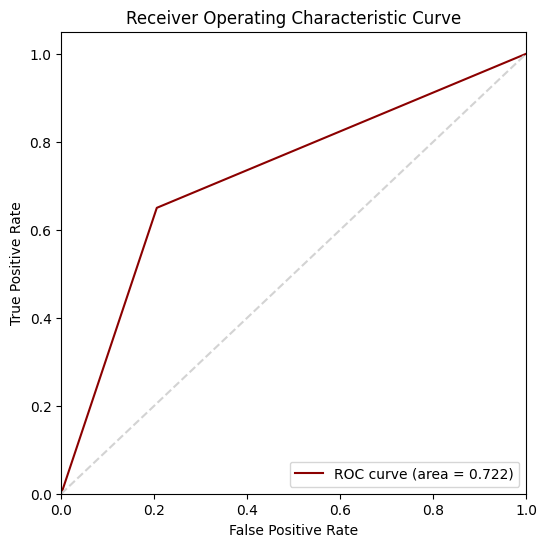

In [21]:
train_preds, val_preds = prediction( model , train_features, train_labels, val_features, val_labels)

In [16]:
#Compute metrics for training set
def compute_metrics(labels,preds):
    
    accuracy = accuracy_score(labels,preds)
    precision = precision_score(labels,preds)
    recall = recall_score(labels,preds)
    f1 = f1_score(labels,preds)
    roc_auc = roc_auc_score(labels,preds)
    # Confusion matrix
    conf_matrix = confusion_matrix(labels,preds)

    # Display the metrics
    print("Training Set Metrics:")
    print("Accuracy: {:.3f}, Precision: {:.3f}, Recall: {:.3f}, F1 Score: {:.3f}, ROC AUC: {:.3f}".format(
        accuracy, precision, recall, f1, roc_auc))
        
    print(conf_matrix) 



In [17]:
compute_metrics(train_labels,train_preds)
compute_metrics(val_labels,val_preds)

Training Set Metrics:
Accuracy: 0.676, Precision: 0.691, Recall: 0.638, F1 Score: 0.663, ROC AUC: 0.676
[[6002 2395]
 [3041 5356]]
Training Set Metrics:
Accuracy: 0.578, Precision: 0.607, Recall: 0.443, F1 Score: 0.512, ROC AUC: 0.578
[[1497  602]
 [1170  929]]


In [18]:
# Create a DataFrame with the metrics


# # Example : 'Logistic Regression - Node Information'
# method = input("Enter the method used for the metrics: ")
# metrics_data = {
#     'Label': [method],
#     'Accuracy': [train_accuracy],
#     'Precision': [train_precision],
#     'Recall': [train_recall],
#     'F1 Score': [train_f1],
#     'ROC AUC': [train_roc_auc]
# }


# metrics_df = pd.DataFrame(metrics_data)
# file_path = 'classification_metrics_monitoring.csv'
# save_header = not os.path.exists(file_path)
# # Save the DataFrame to a CSV file
# metrics_df.to_csv(file_path, mode='a', header=save_header, index=False)

Calculate betweeness centrality
Calculate features for each edge in the graph
Calculate features for each edge in the graph


 43%|████▎     | 1510/3498 [00:04<00:05, 375.95it/s]C:\Users\Guillaume\AppData\Local\Temp\ipykernel_1744\3476036810.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  aai = sum(1 / np.log(graph.degree(z)) for z in nx.common_neighbors(graph, source_node, target_node))
 47%|████▋     | 1629/3498 [00:04<00:04, 386.65it/s]

aai is inf


100%|██████████| 3498/3498 [00:10<00:00, 340.69it/s]


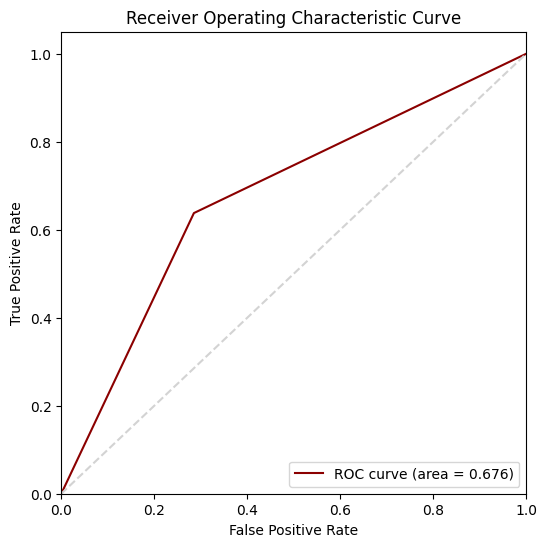

In [19]:
test_features = feature_extractor(G, test_samples, node_information)
# --- Link prediction ---
test_preds = prediction(model,train_features,train_labels, test_features)

In [225]:
logistic_pred = zip(np.array(range(len(test_set))), test_preds)

In [226]:
with open("ggg_predictions.csv","w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in logistic_pred:
         csv_out.writerow(row)
    pred.close()

## Exploration +++++++++++ (not useful)

In [116]:
def create_dgl_graph_with_attributes(train_edges, node_attributes_df, labels):
    # Extract source and destination nodes from the list of training edges
    src_train, dst_train = zip(*train_edges)
    # Extract unique nodes from the training edges
    unique_nodes = set(src_train + dst_train)
    print('Number of unique nodes:', len(unique_nodes))
    # Filter node attributes to include only nodes present in the training set

    filtered_attributes = node_attributes_df[node_attributes_df['node_id'].isin(unique_nodes)]
    # Create a DGL graph from the training edges
    graph = dgl.graph((src_train, dst_train))
    print(graph.num_nodes())
    # Add node attributes to the graph using information from the CSV file
    node_ids = filtered_attributes['node_id'].tolist()
    node_features = torch.tensor(filtered_attributes.iloc[:, 1:].values, dtype=torch.float32)

    graph.ndata['features'] = torch.zeros(graph.num_nodes(), node_features.shape[1])
    graph.ndata['features'][node_ids] = node_features
    # Add labels
    graph.ndata['label'] = torch.tensor(labels, dtype=torch.long)
    
    return graph

In [117]:
# Example usage:
train_edges_list = [(int(edge[0]),int(edge[1])) for edge in train_set]
labels = [int(edge[2]) for edge in train_set]
#Import information about nodes (index represents the node id)
df = pd.read_csv('./node_information.csv', header=None)
df.rename(columns = {0:'node_id'}, inplace = True)
df['node_id'] = df['node_id'].astype(int)

# Extract unique node IDs from the train edges and the node information dataframe
all_node_ids = set()
for edge in train_edges_list:
    all_node_ids.update(edge)
all_node_ids.update(df['node_id'])

# Create a mapping from old IDs to new contiguous IDs
id_mapping = {old_id: new_id for new_id, old_id in enumerate(sorted(all_node_ids))}

# Apply the mapping to re-index the node IDs in train_edges_list
new_train_edges_list = [(id_mapping[edge[0]], id_mapping[edge[1]]) for edge in train_edges_list]

# Apply the mapping to re-index the node IDs in the dataframe
df['node_id'] = df['node_id'].map(id_mapping)

graph = create_dgl_graph_with_attributes(new_train_edges_list, node_attributes_df=df , labels = labels)
print('Number of nodes:', graph.num_nodes())
print('Number of edges:', graph.num_edges())
print('Node features shape:', graph.ndata['features'].shape)

graph = dgl.add_self_loop(graph)
print(graph)

print('Number of nodes:', graph.num_nodes())
print('Number of edges:', graph.num_edges())

Number of unique nodes: 3597
3597


DGLError: Expect number of features to match number of nodes (len(u)). Got 10496 and 3597 instead.

# Explo nodes features for SAGEµ

In [129]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATv2Conv, SAGEConv
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, LinkLoader, NodeLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

In [130]:
node_information = pd.read_csv('node_information.csv', header=None, index_col=0)
train_set = pd.read_csv('train.txt', header=None, sep=' ')
train_set.columns = ['node1', 'node2', 'edge']
test_set = pd.read_csv('test.txt', header=None, sep=' ')
test_set.columns = ['node1', 'node2']

mapping = {node_information.index[i]: i for i in range(len(node_information))}
node_information.index = node_information.index.map(mapping)
train_set["node1"] = train_set["node1"].map(mapping)
train_set["node2"] = train_set["node2"].map(mapping)
test_set["node1"] = test_set["node1"].map(mapping)
test_set["node2"] = test_set["node2"].map(mapping)

In [131]:
train_set["edge"].value_counts()

edge
1    5248
0    5248
Name: count, dtype: int64

In [132]:
def split_dataset(N, train_ratio, seed=4):
    """ Creates train/val/test masks

    Args:
        N (int): dataset size
        train_ratio (float): proportion of the training set
        seed (int, optional): Fixes random. Defaults to 4

    Return:
        [tensors]: returns boolean tensors for train/val/test set
        True indicates that a node belong to this set, False otherwise
    """

    train_size = int(train_ratio * N)
    val_size = N - train_size

    # split dataset
    subsets = torch.utils.data.random_split(range(N), lengths = [train_size, val_size, 0], generator=torch.Generator().manual_seed(seed))
    train_inds, val_inds, test_inds = [torch.Tensor(subset.indices) for subset in subsets]

    # create tensors of masks for each subset
    dataset_inds = torch.arange(N)
    train_mask = torch.isin(dataset_inds, train_inds)
    val_mask = torch.isin(dataset_inds, val_inds)
    test_mask = torch.isin(dataset_inds, test_inds)

    return train_mask, val_mask

train_mask, val_mask = split_dataset(train_set.shape[0], train_ratio=0.8)

In [133]:
degree_per_nodes = np.array([train_set[pd.Series(train_mask)].loc[(train_set["node1"] == i) | (train_set["node2"] == i), "edge"].sum() for i in range(len(node_information))])
degree_per_nodes_standardized = StandardScaler().fit_transform(degree_per_nodes.reshape(-1,1))
node_information[933] = degree_per_nodes_standardized

In [134]:
degree_per_nodes_standardized.shape

(3597, 1)

# Positional node features

random: A feature vector following random distribution is generated
for each node, which is decided by the random seed in
the data initialization. The random feature of each node varies
among training runs with different random seeds initialization.
This feature itself does not reflect relative positions, but it records
a high-dimensional identity for each node, which can indirectly
help GNNs learn the relative node positions.


• one-hot: A unique one-hot vector is initialized for each node
[14, 53]. This feature is essentially equivalent to random, when
the first linear layer of the GNN are randomly initialized.

• eigen: Eigen decomposition is performed on the normalized adjacency
matrix and then the top k eigen vectors are used to generate
a k-dimensional feature vector for each node [7, 22, 58], where
the optimal value of k is decided by grid search [33].

• deepwalk: The initial feature of a node is generated based on the
DeepWalk algorithm from [37] with the walk length set as 40 by
default. Deep walk features with walk length longer than 2 can
help to capture higher-order positional information in the graph.

In [135]:


"""random: A feature vector following random distribution is generated
for each node, which is decided by the random seed in
the data initialization. The random feature of each node varies
among training runs with different random seeds initialization.
This feature itself does not reflect relative positions, but it records
a high-dimensional identity for each node, which can indirectly
help GNNs learn the relative node positions."""
random_features = np.random.rand(len(node_information), 128)
random_features.shape

(3597, 128)

In [136]:
""" A unique one-hot vector is initialized for each node
[14, 53]. This feature is essentially equivalent to random, when
the first linear layer of the GNN are randomly initialized."""
one_hot_features = np.eye(len(node_information))
one_hot_features.shape


(3597, 3597)

In [137]:
"""
• eigen: Eigen decomposition is performed on the normalized adjacency
matrix and then the top k eigen vectors are used to generate
a k-dimensional feature vector for each node [7, 22, 58], where
the optimal value of k is decided by grid search [33]."""
# # Calculte the eigen features
# adjacency = np.zeros((len(node_information), len(node_information)))
# for i, j in zip(train_set[pd.Series(train_mask)]["node1"], train_set[pd.Series(train_mask)]["node2"]):
#     adjacency[i, j] = 1
#     adjacency[j, i] = 1
# # normalize the adjacency matrix
# degree = np.diag(adjacency.sum(axis=1))
# degree_inv_sqrt = np.linalg.inv(np.sqrt(degree))
# adjacency_normalized = degree_inv_sqrt @ adjacency @ degree_inv_sqrt
# eigen_values, eigen_vectors = np.linalg.eig(adjacency_normalized)
# # Select the top k eigen vectors
# k = 128
# eigen_features = eigen_vectors[:, :k]
# eigen_features.shape

'\n• eigen: Eigen decomposition is performed on the normalized adjacency\nmatrix and then the top k eigen vectors are used to generate\na k-dimensional feature vector for each node [7, 22, 58], where\nthe optimal value of k is decided by grid search [33].'

In [138]:
# Step 1: Create the residual graph G'
G_prime = nx.Graph()

# Step 2: Add nodes from G that are part of the training set to G'
for node in list(train_set["node1"].values):
    G_prime.add_node(node)
for node in list(train_set["node2"].values):
    G_prime.add_node(node)

# Step 3: Add edges from G that are between nodes in the training set
for edge in pd.DataFrame(train_set)[pd.Series(train_mask)][["node1","node2"]].values:
    G_prime.add_edge(edge[0], edge[1])
# Display G
print("The number of nodes: {}".format(G_prime.number_of_nodes()))
print("The number of edges: {}".format(G_prime.number_of_edges()))
# Check that the graph is connected
print("The number of connected components: {}".format(nx.number_connected_components(G_prime)))

The number of nodes: 3597
The number of edges: 8396
The number of connected components: 44


In [139]:

"""• deepwalk: The initial feature of a node is generated based on the
DeepWalk algorithm from [37] with the walk length set as 40 by
default. Deep walk features with walk length longer than 2 can
help to capture higher-order positional information in the graph."""


# Assuming you already have train_graph as a NetworkX graph

# Step 1: Convert train graph to edge list format
# If your graph is already in edge list format, you can skip this step


# # Step 2: Save graph to a file
# nx.write_edgelist(G_prime, 'train_graph.edgelist')

# # Step 3: Run DeepWalk algorithm
# # Initialize DeepWalk with parameters
# deepwalk = DeepWalk(
#     walk_length=40,
#     number_walks=10,  # Number of walks per node
#     workers=1  # Number of parallel processes
# )

# # Load graph from edge list file
# deepwalk.load_graph('train_graph.edgelist')

# # Generate embeddings
# embeddings = deepwalk.train(window_size=5, iter=1, embed_size=64)



'• deepwalk: The initial feature of a node is generated based on the\nDeepWalk algorithm from [37] with the walk length set as 40 by\ndefault. Deep walk features with walk length longer than 2 can\nhelp to capture higher-order positional information in the graph.'

# Structural Node Features

shared: An initial feature vector is shared across all nodes [14].
The shared feature we used is simply a vector of all 1’s.

• degree: An one-hot degree vector is initialized for each node,
whose dimension is decided by the max degree of all nodes [16,
47].

• pagerank: The original PageRank score [4] of a given node is
calculated and then flattened into a vector in order to fully utilize
the embedding dimensions of neural networks, where the dimension
of the extended vector is selected by grid-search [33]. It can
be viewed as generalized higher-order node degree information.

In [140]:
"""shared: An initial feature vector is shared across all nodes [14].
The shared feature we used is simply a vector of all 1’s."""
shared_features = np.ones((len(node_information), 128))
shared_features.shape


(3597, 128)

In [141]:
"""• degree: An one-hot degree vector is initialized for each node,
whose dimension is decided by the max degree of all nodes [16,
47]."""
# One hot degree vector
degree_per_nodes = np.array([train_set[pd.Series(train_mask)].loc[(train_set["node1"] == i) | (train_set["node2"] == i), "edge"].sum() for i in range(len(node_information))])
max_degree = degree_per_nodes.max()
degree_features = np.eye(max_degree + 1)[degree_per_nodes]
degree_features.shape

(3597, 300)

In [142]:
""" pagerank: The original PageRank score [4] of a given node is
calculated and then flattened into a vector in order to fully utilize
the embedding dimensions of neural networks, where the dimension
of the extended vector is selected by grid-search [33]. It can
be viewed as generalized higher-order node degree information."""
# Calculate the pagerank
pagerank = nx.pagerank(nx.from_pandas_edgelist(train_set[pd.Series(train_mask)], "node1", "node2"))
pagerank = np.array([pagerank[i] if i in pagerank else 0 for i in range(len(node_information))])
pagerank_standardized = StandardScaler().fit_transform(pagerank.reshape(-1,1))
pagerank_standardized.shape

(3597, 1)

In [144]:
# Add features to the node_information dataframe like node_information[933] = degree_per_nodes_standardized
node_information[933] = degree_per_nodes_standardized.tolist()
node_information[934] = pagerank_standardized.tolist()
# Transform pagerank column into a float
node_information[934] = node_information[934].apply(lambda x: x[0])
node_information[933] = node_information[933].apply(lambda x: x[0])
# node_information[935] = random_features.tolist()
# node_information[936] = one_hot_features.tolist()
# node_information[937] = shared_features.tolist()
# node_information[938] = degree_features.tolist()


In [145]:
node_information

,1,2,3,4,5,6,7,8,9,10,...,925,926,927,928,929,930,931,932,933,934
0,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056423,0.528356
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.232140,0.008631
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056423,-0.076597
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056423,-0.095056
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056423,0.716594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056423,-0.427287
3593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.056423,-0.100792
3594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.232140,-0.464677


In [146]:
class GATModel(nn.Module):
  def __init__(self, input_size, hidden_size, hidden_size_bis, output_size_embed):
    super().__init__()
    # self.conv1 = GATv2Conv(input_size, hidden_size, heads=6)
    # self.conv2 = GATv2Conv(6 * hidden_size, hidden_size, heads=4)
    # self.conv3 = GATv2Conv(4 * hidden_size, hidden_size_bis, heads=4)
    # self.conv4 = GATv2Conv(4 * hidden_size_bis, output_size_embed, heads=6, concat=False)

    self.conv1 = SAGEConv(input_size, hidden_size, aggr="max")
    self.conv2 = SAGEConv(hidden_size, hidden_size_bis, aggr="mean")
    self.conv3 = SAGEConv(hidden_size_bis, hidden_size_bis//2, aggr="max")
    self.conv4 = SAGEConv(hidden_size_bis//2, hidden_size_bis//2, aggr="mean")
    self.conv5 = SAGEConv(hidden_size_bis//2, output_size_embed, aggr="max")

    self.lin1 = nn.Linear(2 * output_size_embed, output_size_embed)
    self.lin2 = nn.Linear(output_size_embed, output_size_embed)
    self.lin3 = nn.Linear(output_size_embed, output_size_embed//2)
    self.lin4 = nn.Linear(output_size_embed//2, 2)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv2(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv3(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv4(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.conv5(x, edge_index)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)

    row, col = edge_index
    x = torch.cat([x[row], x[col]], dim=1)
    x = self.lin1(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin2(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin3(x)
    x = nn.functional.elu(x)
    x = nn.functional.dropout(x, p=0.5)
    x = self.lin4(x)

    return x

In [147]:
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y.float())
        predict = np.where(output.detach().cpu().numpy()[:, 1] >= 0, 1, 0)
        score = accuracy_score(batch.y.cpu().numpy()[:, 1], predict)
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

In [148]:
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            output = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(output, train_batch_device.y.float())
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("Accuracy Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

In [149]:
x = torch.tensor(node_information.values, dtype=torch.float)

y_train = torch.tensor(train_set['edge'].values[train_mask], dtype=torch.long)
y_train = torch.tensor([[1 if y_train[i]==0 else 0, 1 if y_train[i]==1 else 0] for i in range(len(y_train))])
edge_index_train = torch.tensor(train_set[['node1', 'node2']].values.T[torch.vstack([train_mask, train_mask])].reshape(2, -1), dtype=torch.long)

y_val = torch.tensor(train_set['edge'].values[val_mask], dtype=torch.long)
y_val = torch.tensor([[1 if y_val[i]==0 else 0, 1 if y_val[i]==1 else 0] for i in range(len(y_val))])
edge_index_val = torch.tensor(train_set[['node1', 'node2']].values.T[torch.vstack([val_mask, val_mask])].reshape(2, -1), dtype=torch.long)

edge_index_test = torch.tensor(test_set[['node1', 'node2']].values.T, dtype=torch.long)

data_train = Data(x=x, edge_index=edge_index_train, y=y_train)
data_val = Data(x=x, edge_index=edge_index_val, y=y_val)


batch_size = 32
train_data_loader = NeighborLoader(data_train, num_neighbors=[-1], batch_size=batch_size, shuffle=True)
val_data_loader = NeighborLoader(data_val, num_neighbors=[-1], batch_size=batch_size, shuffle=True)

In [150]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

# Create the GAT model
model = GATModel(input_size=x.shape[1], hidden_size=500, hidden_size_bis=400, output_size_embed=300).to(device)

# Define the loss function and optimizer
loss_fcn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

max_epochs=200


Device:  cpu


In [151]:
# Train with mini-batches
epoch_list, model_scores = train(
    model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_data_loader,
    val_data_loader,
)

ImportError: 'NeighborSampler' requires either 'pyg-lib' or 'torch-sparse'

In [ ]:
# Evaluation on val set batch

score_list_batch = []
predict_list_batch = []
y_list_batch = []

model.eval()
for i, batch in enumerate(val_data_loader):
    batch = batch.to(device)
    output = model(batch.x, batch.edge_index)
    predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
    score = accuracy_score(batch.y.cpu().numpy()[:, 1], predict[:, 1])

    score_list_batch.append(score)
    predict_list_batch.append(predict)
    y_list_batch.append(batch.y.cpu().numpy()[:, 1].mean())

In [ ]:
np.array((score_list_batch)).mean()

0.635291542545112

In [ ]:
# Train without mini-batches
data_train_device = data_train.to(device)
data_val_device = data_val.to(device)

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data_train_device.x, data_train_device.edge_index)
    loss = loss_fcn(out, data_train_device.y.float())
    loss.backward()
    optimizer.step()

    print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss.item()))


    model.eval()
    output = model(data_val_device.x, data_val_device.edge_index)
    loss_test = loss_fcn(output, data_val_device.y.float())
    predict = np.where(output.detach().cpu().numpy()[:, 1] >= 0.5, 1, 0)
    score = accuracy_score(data_val_device.y.cpu().numpy()[:, 1], predict)
    print("Accuracy core: {:.4f}".format(score))

Epoch 00001 | Loss: 0.4077
Accuracy core: 0.6567
Epoch 00002 | Loss: 0.4155
Accuracy core: 0.6619
Epoch 00003 | Loss: 0.4213
Accuracy core: 0.6614
Epoch 00004 | Loss: 0.4268
Accuracy core: 0.6605
Epoch 00005 | Loss: 0.4148
Accuracy core: 0.6629
Epoch 00006 | Loss: 0.4242
Accuracy core: 0.6643
Epoch 00007 | Loss: 0.4163
Accuracy core: 0.6643
Epoch 00008 | Loss: 0.4213
Accuracy core: 0.6705
Epoch 00009 | Loss: 0.4162
Accuracy core: 0.6605
Epoch 00010 | Loss: 0.4096
Accuracy core: 0.6567
Epoch 00011 | Loss: 0.4176
Accuracy core: 0.6562
Epoch 00012 | Loss: 0.4082
Accuracy core: 0.6600
Epoch 00013 | Loss: 0.4162
Accuracy core: 0.6657
Epoch 00014 | Loss: 0.4126
Accuracy core: 0.6610
Epoch 00015 | Loss: 0.4112
Accuracy core: 0.6638
Epoch 00016 | Loss: 0.4126
Accuracy core: 0.6710
Epoch 00017 | Loss: 0.4081
Accuracy core: 0.6643
Epoch 00018 | Loss: 0.4154
Accuracy core: 0.6605
Epoch 00019 | Loss: 0.4054
Accuracy core: 0.6671
Epoch 00020 | Loss: 0.4123
Accuracy core: 0.6652
Epoch 00021 | Loss: 

In [ ]:
model.eval()
output = model(x.to(device), edge_index_test.to(device))
pred_test = np.where(output.detach().cpu().numpy() >= 0, 1, 0)[:, 1]

In [ ]:
pred_test

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
preds = zip(np.array(range(len(test_set))), pred_test)

In [ ]:
import os
import csv

os.makedirs("models", exist_ok=True)
i = len(os.listdir("models")) +1
model_path = f"models/model_{i}.csv"

with open(model_path,"w") as pred:
    csv_out = csv.writer(pred)
    csv_out.writerow(i for i in ["ID", "Predicted"])
    for row in preds:
         csv_out.writerow(row)
    pred.close()
